# Data Scrapping

In [1]:
import pandas as pd
import os
from datetime import datetime
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import subprocess
import names
from selenium.webdriver.common.by import By
import time
import math
import random 
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
email = "maskradiogreece@gmail.com"
password = "code1234567"
now = datetime.now()

In [3]:
recorded_time = round(datetime.timestamp(now))
def scrap_profile(name,count):
    try:
        command = "instagram-scraper --user " + name + " -u " + email + " -p " + password + " -m " + str(count) + " --cookiejar cookies --media-metadata -t none -d " + str(recorded_time)  
        subprocess.check_output(command)
    except subprocess.CalledProcessError as error:
        print("FAILED!!!!!!!!")
        raise Exception(error.output.decode("utf8"))
        

In [4]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [5]:
driver = webdriver.Chrome("../Data/chromedriver_win32/chromedriver.exe")
driver.maximize_window()
driver.get("https://www.instagram.com/")
time.sleep(5)
buttons = driver.find_elements_by_tag_name("button")
time.sleep(1)
buttons[2].click()
login_inputs = driver.find_elements_by_tag_name("input")
time.sleep(1)
login_inputs[0].send_keys(email)
time.sleep(1)
login_inputs[1].send_keys(password)
time.sleep(1)
buttons[0].click()
time.sleep(5)
driver.get("https://www.instagram.com/")
time.sleep(2)
notification_button = driver.find_elements(By.XPATH, '//button[text()="Όχι τώρα"]')
time.sleep(1)
notification_button[0].click()

In [ ]:
time.sleep(10)
total_count = 0
loop = 1
max_request_pattern = re.compile(r'429 Client Error')
while True:
    driver.get("https://www.instagram.com/")
    inputs = driver.find_elements_by_tag_name("input")
    # The 3rd one is the search 
    search = inputs[2]
    random_name = names.get_first_name() 
    search.send_keys(random_name)
    time.sleep(10)
    # Get List of Users
    user_list = driver.find_elements(By.XPATH, '//div[@role="none"]')
    # Create List 
    profile_links = []
    for user in user_list:
        link = user.find_element_by_tag_name("a")
        link = link.get_attribute("href")
        if link.find("explore") == -1:
            profile_links.append(link)
    searched_links = pd.read_csv("./Links.csv")
    searched_links = searched_links["Links"].to_list()
    print(f"Going to scrap {len(profile_links)} profiles searching for {random_name}")
    for link in profile_links:
        name = link.split("/")[3]
        if link in searched_links:
            print(f"SKIPPING ====> USER {name} ALREADY SCRAPED ")
            continue
        driver.get(link);
        try:
            is_private = driver.find_element(By.XPATH, "//*[text()[contains(., 'Αυτός ο λογαριασμός είναι ιδιωτικός')]]" )
            continue 
        except: 
            post = driver.find_element(By.XPATH, "//*[text()[contains(., 'δημοσιεύσεις') or contains(., 'δημοσίευση')]]" )
            num_posts = int(post.find_element_by_tag_name("span").get_attribute("innerHTML").replace(",",""))
            if num_posts < 20:
                print(f"SKIPPING ====> USER {name} HAS LESS THAN 20 POSTS")
                continue
            get_num_posts = min(num_posts,200)
            print(f"FETCHING ====> Getting {get_num_posts} from {name}")
            try:
                scrap_profile(name,get_num_posts)
                total_count += get_num_posts
                print(f"TOTAL ====> Aquired {total_count} data from {loop} users")
                if total_count > 90:
                    print("EXITING ====> 90 USERS LIMIT SCRAPPED")
                    raise StopExecution
                loop += 1
                time.sleep(random.randint(10,60))
            except Exception as error:
                max_request_limit_reached = re.search(max_request_pattern,str(error))
                if max_request_limit_reached != None:
                    print("EXITING ====> MAX REQUEST API LIMIT REACHED")
                    raise StopExecution
                else:
                    print(f"SKIPPING ====>SOMETHING WENT WRONG SCRAPPING USER {name}")
                    continue
        searched_links.append(link)
        df = pd.DataFrame(searched_links,columns=["Links"])
        df.to_csv('./Links.csv',index=False)

Going to scrap 44 profiles searching for Michael
FETCHING ====> Getting 200 from michaeljackson


# Dataframe Creation

In [9]:
main_folder = "JsonData"

user_uuid = []
images = []
likes = []
like_percentages = []
days_count = []
num_of_tags = []
num_of_comments = []
date_posted = []
type = []
count = 1
for folder_name in os.listdir(f"./{main_folder}/"):
    folder_time_recorded = datetime.fromtimestamp(int(folder_name))
    for file_name in os.listdir(f"./{main_folder}/{folder_name}/"):
        file = open(f'./{main_folder}/{folder_name}/{file_name}', encoding="utf8")
        data = json.load(file)
        sub_likes = []
        i = 1
        for item in data["GraphImages"]:
            if item["__typename"] == "GraphImage":
                type.append("Image")
            elif item["__typename"] == "GraphVideo":
                type.append("Video")
            else:
                type.append("Images")
            # If the post is at least 2 days old then add it to data or else skip it
            user_uuid.append(count)
            likes.append(item["edge_media_preview_like"]["count"])
            try:
                num_of_tags.append(len(item["tags"]))
            except:
                num_of_tags.append(0)
            num_of_comments.append(item["edge_media_to_comment"]["count"])
            sub_likes.append(item["edge_media_preview_like"]["count"])
            date = datetime.fromtimestamp(item["taken_at_timestamp"])
            date_posted.append(date)
            days_count.append((datetime.today() - datetime.fromtimestamp(item["taken_at_timestamp"])).days)
        maxLikes = max(sub_likes)
        sub_like_percentages = []
        for like in sub_likes:
            sub_like_percentages.append(round(like/maxLikes,2))
        like_percentages += sub_like_percentages
        count += 1
        file.close()

In [10]:
df = pd.DataFrame(user_uuid,columns=["User uuid"])

In [11]:
df["Likes"] = likes
df["Days passed from post"] = days_count
df["Likes Score"] = like_percentages
df["Type"] = type
df["Numer of Tags"] = num_of_tags
df["Numer of Comments"] = num_of_comments
df["Date Posted"] = date_posted
df['Year'] = df['Date Posted'].dt.year
df['Month'] = df['Date Posted'].dt.month
df['Day'] = df['Date Posted'].dt.day
df['Hour'] = df['Date Posted'].dt.hour
df['Minute'] = df['Date Posted'].dt.minute

# Dataframe Exploration

In [12]:
df.head()

,User uuid,Likes,Days passed from post,Likes Score,Type,Numer of Tags,Numer of Comments,Date Posted,Year,Month,Day,Hour,Minute
0,1,506,642,0.74,Image,3,11,2019-05-12 21:18:39,2019,5,12,21,18
1,1,385,643,0.57,Image,0,1,2019-05-12 14:25:55,2019,5,12,14,25
2,1,373,652,0.55,Images,4,15,2019-05-03 15:18:37,2019,5,3,15,18
3,1,312,653,0.46,Images,4,1,2019-05-02 16:40:38,2019,5,2,16,40
4,1,513,660,0.75,Images,5,0,2019-04-25 16:51:58,2019,4,25,16,51


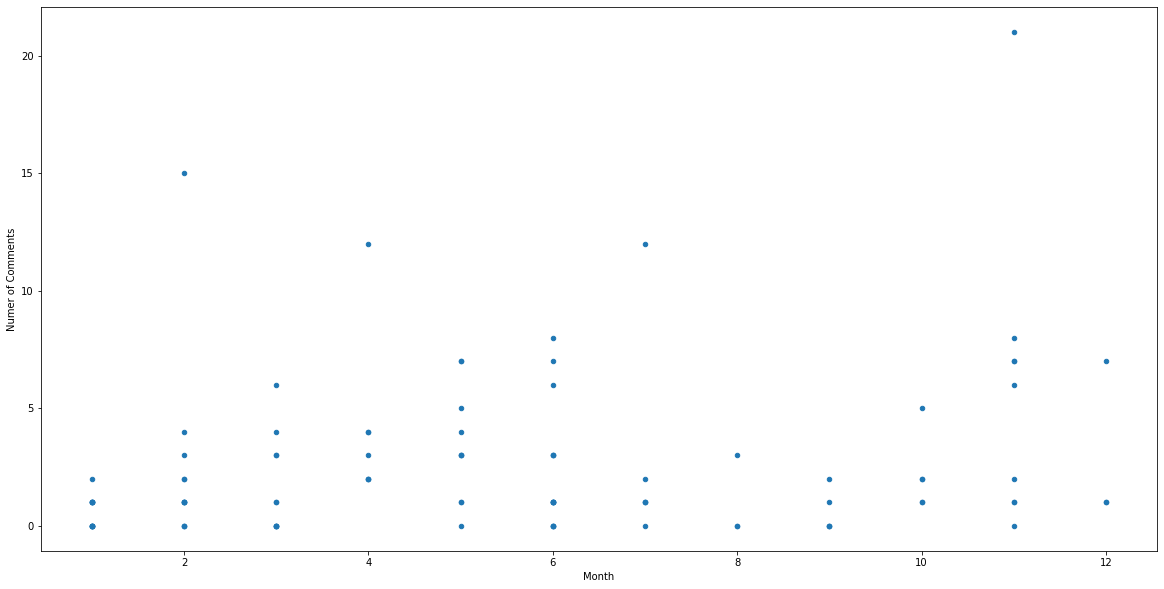

In [46]:
df[df["User uuid"]==8].plot.scatter("Month","Numer of Comments",figsize=(20,10))

In [47]:
df.plot.pcolormesh("Month","Numer of Comments")

AttributeError: 'PlotAccessor' object has no attribute 'pcolormesh'